# Prosody Evaluation Notebook

This notebook provides an **automated**, objective evaluation of the **intonation** aspect of your TTS system by comparing synthesized audio against ground‑truth human recordings.

**Workflow:**
1. **Merge** segmented natural recordings (`Data/voice/{ID}/audio/segment_ph*.wav`) into a single reference waveform per episode.
2. **Load** the corresponding synthesized audio (`Out/results/{ID}/OUT.wav`).
3. **Extract** fundamental frequency (F₀) contours with `librosa.pyin`.
4. **Align** voiced frames via Dynamic Time Warping (DTW).
5. **Compute** the RMSE of log‑F₀ over the DTW path:
   \[
     \mathrm{RMSE}_{f_0} \;=\;\sqrt{\frac{1}{T}\sum_{(i,j)\in\mathrm{DTW}} 
     \bigl(\log y_i - \log y'_j\bigr)^2}\,,
   \]
   where \(T\) is the number of aligned voiced frames.
6. **Report** per‑episode and overall RMSE scores and visualize them in a bar chart.

> **Note:** The script **automatically resamples** any synthetic audio to match the reference sample rate.

---


### Import libraries

In [11]:
import os
import tempfile
import soundfile as sf
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import torch
import torchcrepe
from pathlib import Path
from tqdm.notebook import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import whisper_timestamped as whisper
from jiwer import wer as compute_wer
import json
from IPython.display import HTML, display
import difflib
import textwrap

In [ ]:
whisper_model = whisper.load_model("large-v3", device="cuda")  # or "cpu"

# -----------------------------------------------------------------------------
# Helpers: extract transcript + break times from an audio file
# -----------------------------------------------------------------------------
def extract_transcript_and_breaks(audio_path: Path, break_tol: float = 0.3):
    """
    Run WhisperTimestampedModel on `audio_path` to get:
      - full transcript text
      - list of phrase-break times (segment end times)
      - list of segments with start, end, and text
    Returns (transcript: str, breaks: List[float], segments: List[dict]).
    """
    result = whisper_model.transcribe(str(audio_path))
    # Full transcript
    text = result["text"].strip()
    # Segment end times as break points (ignore final)
    breaks = [seg["end"] for seg in result["segments"][:-1]]
    # Segments with start, end, and text
    segments = [
        {"start": seg["start"], "end": seg["end"], "text": seg["text"].strip()}
        for seg in result["segments"]
    ]
    return text, breaks, segments

def compute_f1_break(breaks_ref, breaks_sys, tol=0.3):
    """
    Match each reference break to a system break within ±tol seconds.
    Returns (f1, precision, recall).
    """
    tp = 0
    used_sys = set()
    for r in breaks_ref:
        for i, s in enumerate(breaks_sys):
            if i in used_sys: 
                continue
            if abs(r - s) <= tol:
                tp += 1
                used_sys.add(i)
                break
    fp = len(breaks_sys) - len(used_sys)
    fn = len(breaks_ref) - tp
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
    return f1, prec, rec

def merge_segments(ep_id: str, voice_base: Path):
    """
    Load & concatenate all segment_ph*.wav under Data/voice/{ep_id}/audio/,
    automatically resampling each segment to a common sample rate.
    Returns:
      y_ref (np.ndarray): merged waveform
      sr_ref (int): reference sample rate
    """
    audio_dir = voice_base / ep_id / "audio"
    segs = sorted(audio_dir.glob("segment_ph*.wav"))
    if not segs:
        raise FileNotFoundError(f"No segments found for '{ep_id}' in {audio_dir}")

    concatenated = []
    sr_ref = None

    for seg in segs:
        # 1a) load the raw segment (at its native sampling rate)
        y, sr = librosa.load(seg, sr=None)

        if sr_ref is None:
            # 1b) first file sets our reference sample rate
            sr_ref = sr
        elif sr != sr_ref:
            # 1c) resample any outliers to the reference rate
            y = librosa.resample(y, orig_sr=sr, target_sr=sr_ref)

        concatenated.append(y)

    # 1d) stitch them end‑to‑end
    return np.concatenate(concatenated), sr_ref

def extract_f0_torchcrepe(
    y: np.ndarray,
    sr: int,
    hop_length: int = 512,
    fmin: float = None,
    fmax: float = None,
    model: str = "full",
    threshold: float = 0.1,
    batch_size: int = 4096,
    device: str = "cuda:0",
) -> np.ndarray:
    """
    Run torchcrepe.predict on y to get an F0 contour (Hz) with NaN for unvoiced frames.
    """

    # 1) Force mono and float32
    if y.ndim > 1:
        y = librosa.to_mono(y)
    y = y.astype(np.float32)

    # 2) Set sensible defaults for f0 range
    if fmin is None:
        fmin = librosa.note_to_hz("C2")
    if fmax is None:
        fmax = librosa.note_to_hz("C6")

    # 3) Build a [1×T] Tensor on the right device
    audio = torch.from_numpy(y).to(device).unsqueeze(0)

    # 4) Predict (returns two [1×T] tensors when return_periodicity=True)
    pitch_t, periodicity_t = torchcrepe.predict(
        audio,
        sr,
        hop_length,
        fmin,
        fmax,
        model,
        batch_size=batch_size,
        device=device,
        return_periodicity=True,
    )

    # 5) Detach → CPU → NumPy
    pitch = pitch_t.squeeze(0).detach().cpu().numpy()
    periodicity = periodicity_t.squeeze(0).detach().cpu().numpy()

    # 6) Mask out unvoiced frames
    pitch[periodicity < threshold] = np.nan

    return pitch


def compute_f0_rmse(
    y_ref: np.ndarray,
    y_sys: np.ndarray,
    sr: int,
    hop_length: int = 512,
    fmin: float = None,
    fmax: float = None,
    model: str = "full",
    threshold: float = 0.1,
    batch_size: int = 4096,
    device: str = "cuda:0",
) -> float:
    """
    RMSE of log-F0 via TorchCREPE + dtaidistance’s C-DTW.
    """

    # 1) Extract F0 for both signals
    f0_ref = extract_f0_torchcrepe(
        y_ref, sr,
        hop_length=hop_length,
        fmin=fmin, fmax=fmax,
        model=model,
        threshold=threshold,
        batch_size=batch_size,
        device=device
    )
    f0_sys = extract_f0_torchcrepe(
        y_sys, sr,
        hop_length=hop_length,
        fmin=fmin, fmax=fmax,
        model=model,
        threshold=threshold,
        batch_size=batch_size,
        device=device
    )

    # 2) Keep only voiced frames and log-transform
    mask_r = ~np.isnan(f0_ref)
    mask_s = ~np.isnan(f0_sys)
    log_r = np.log(f0_ref[mask_r])
    log_s = np.log(f0_sys[mask_s])
    if log_r.size == 0 or log_s.size == 0:
        return np.nan

    # 3) Compute the exact DTW warping path
    dist, path = fastdtw(log_r, log_s, radius=25)
    wp = np.array(path)
    diffs = log_r[wp[:,0]] - log_s[wp[:,1]]
    return float(np.sqrt(np.mean(diffs**2)))

In [5]:
def process_episode(ep_id: str, voice_base: str, results_base: str, save_dir: str):
    pbar = tqdm(total=8, desc=f"[{ep_id}]", leave=False)
    try:
        vb = Path(voice_base)
        rb = Path(results_base)
        save_path = Path(save_dir) / ep_id
        save_path.mkdir(parents=True, exist_ok=True)

        # 1) Merge & write reference
        # pbar.set_description(f"[{ep_id}] Merging segments")
        # y_ref, sr_ref = merge_segments(ep_id, vb)
        # ref_audio_path = save_path / "reference.wav"
        # sf.write(ref_audio_path, y_ref, sr_ref)
        # pbar.update(1)

        # 1) Load single “demucs” reference instead of merging segments
        pbar.set_description(f"[{ep_id}] Loading demucs reference")
        demucs_path = vb / ep_id / "brute" / "segment_demucs.wav"
        if not demucs_path.exists():
            raise FileNotFoundError(f"No demucs file at {demucs_path}")
        y_ref, sr_ref = librosa.load(demucs_path, sr=None)
        ref_audio_path = save_path / "reference.wav"
        sf.write(ref_audio_path, y_ref, sr_ref)
        pbar.update(1)

        # 2) Extract ref breaks + transcript + segments
        pbar.set_description(f"[{ep_id}] Extracting reference breaks")
        ref_txt, ref_breaks, ref_segments = extract_transcript_and_breaks(ref_audio_path)
        with open(save_path / "reference_transcript.txt", "w") as f:
            f.write(ref_txt)
        with open(save_path / "reference_breaks.txt", "w") as f:
            f.write("\n".join(map(str, ref_breaks)))
        with open(save_path / "reference_segments.json", "w") as f:
            json.dump(ref_segments, f)
        pbar.update(1)

        # 3) Load & resample synthetic
        pbar.set_description(f"[{ep_id}] Loading synthetic")
        sys_path = rb / ep_id / "OUT.wav"
        if not sys_path.exists():
            pbar.close()
            return ep_id, np.nan, np.nan, np.nan, "Missing OUT.wav"
        y_sys, sr_sys = librosa.load(sys_path, sr=None)
        if sr_sys != sr_ref:
            y_sys = librosa.resample(y_sys, orig_sr=sr_sys, target_sr=sr_ref)
        sys_audio_path = save_path / "synthetic.wav"
        sf.write(sys_audio_path, y_sys, sr_ref)
        pbar.update(1)

        # 4) Extract synth breaks + transcript + segments
        pbar.set_description(f"[{ep_id}] Extracting synthetic breaks")
        sys_txt, sys_breaks, sys_segments = extract_transcript_and_breaks(sys_audio_path)
        with open(save_path / "synthetic_transcript.txt", "w") as f:
            f.write(sys_txt)
        with open(save_path / "synthetic_breaks.txt", "w") as f:
            f.write("\n".join(map(str, sys_breaks)))
        with open(save_path / "synthetic_segments.json", "w") as f:
            json.dump(sys_segments, f)
        pbar.update(1)

        # 5) Compute metrics: RMSE_f0, F1_break, WER
        pbar.set_description(f"[{ep_id}] Computing RMSE")
        rmse_f0 = compute_f0_rmse(y_ref, y_sys, sr_ref)
        pbar.update(1)
        pbar.set_description(f"[{ep_id}] Computing F1_break")
        f1_b, prec_b, rec_b = compute_f1_break(ref_breaks, sys_breaks, tol=0.3)
        pbar.update(1)
        pbar.set_description(f"[{ep_id}] Computing WER")
        wer_score = compute_wer(ref_txt, sys_txt)
        pbar.update(1)

        pbar.update(1)
        pbar.close()
        return ep_id, rmse_f0, f1_b, wer_score, None

    except Exception as e:
        pbar.close()
        return ep_id, np.nan, np.nan, np.nan, str(e)

# -----------------------------------------------------------------------------
# Parallel evaluation driver
# -----------------------------------------------------------------------------
def evaluate_all(
    voice_base: str,
    results_base: str,
    save_dir: str,
    parallel: bool = True,
    max_workers: int = None
) -> pd.DataFrame:
    vb = Path(voice_base)
    rb = Path(results_base)
    ep_ids = sorted([p.name for p in rb.iterdir() if p.is_dir()])
    records = []

    if parallel:
        with ProcessPoolExecutor(max_workers=max_workers) as executor:
            futures = {
                executor.submit(process_episode, ep, voice_base, results_base, save_dir): ep
                for ep in ep_ids
            }
            for future in tqdm(
                as_completed(futures),
                total=len(futures),
                desc="Evaluating episodes"
            ):
                ep_id, rmse, f1_b, wer_score, err = future.result()
                if err:
                    print(f"❌ {ep_id}: {err}")
                else:
                    print(f"✅ {ep_id}: RMSE={rmse:.3f}, F1_break={f1_b:.3f}, WER={wer_score:.3f}")
                    records.append({
                        "episode": ep_id,
                        "rmse_f0": rmse,
                        "f1_break": f1_b,
                        "wer": wer_score
                    })

    else:
        for ep_id in tqdm(ep_ids, desc="Evaluating episodes"):
            ep_id, rmse, f1_b, wer_score, err = process_episode(ep_id, voice_base, results_base, save_dir)
            if err:
                print(f"❌ {ep_id}: {err}")
            else:
                print(f"✅ {ep_id}: RMSE={rmse:.3f}, F1_break={f1_b:.3f}, WER={wer_score:.3f}")
                records.append({
                    "episode": ep_id,
                    "rmse_f0": rmse,
                    "f1_break": f1_b,
                    "wer": wer_score
                })

    df = pd.DataFrame(records).set_index("episode")
    print("\nOverall metrics:")
    print(df.mean())
    df.plot.bar(subplots=True, layout=(1,3), figsize=(12,4), legend=False)
    plt.tight_layout()
    plt.show()

    return df

### Run the evaluation script

Evaluating episodes:   0%|          | 0/10 [00:00<?, ?it/s]

[Aznavour_EP03]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Aznavour_EP03: RMSE=0.371, F1_break=0.031, WER=0.970


[Aznavour_EP04]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ Aznavour_EP04: RMSE=0.146, F1_break=0.067, WER=0.876


[BERTRAND_PERIER_EP01]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BERTRAND_PERIER_EP01: RMSE=0.158, F1_break=0.217, WER=0.458


[BERTRAND_PERIER_EP02]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BERTRAND_PERIER_EP02: RMSE=0.179, F1_break=0.232, WER=0.973


[BERTRAND_PERIER_EP03]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BERTRAND_PERIER_EP03: RMSE=0.202, F1_break=0.331, WER=0.406


[BERTRAND_PERIER_EP04]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BERTRAND_PERIER_EP04: RMSE=0.194, F1_break=0.185, WER=0.372


[BERTRAND_PERIER_EP05]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BERTRAND_PERIER_EP05: RMSE=0.189, F1_break=0.360, WER=0.376


[BIO_CELINE_EP01]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BIO_CELINE_EP01: RMSE=0.249, F1_break=0.265, WER=0.212


[BIO_CELINE_EP02]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BIO_CELINE_EP02: RMSE=0.261, F1_break=0.208, WER=0.268


[BIO_CELINE_EP03]:   0%|          | 0/8 [00:00<?, ?it/s]

✅ BIO_CELINE_EP03: RMSE=0.267, F1_break=0.196, WER=0.202

Overall metrics:
rmse_f0     0.221634
f1_break    0.209112
wer         0.511049
dtype: float64


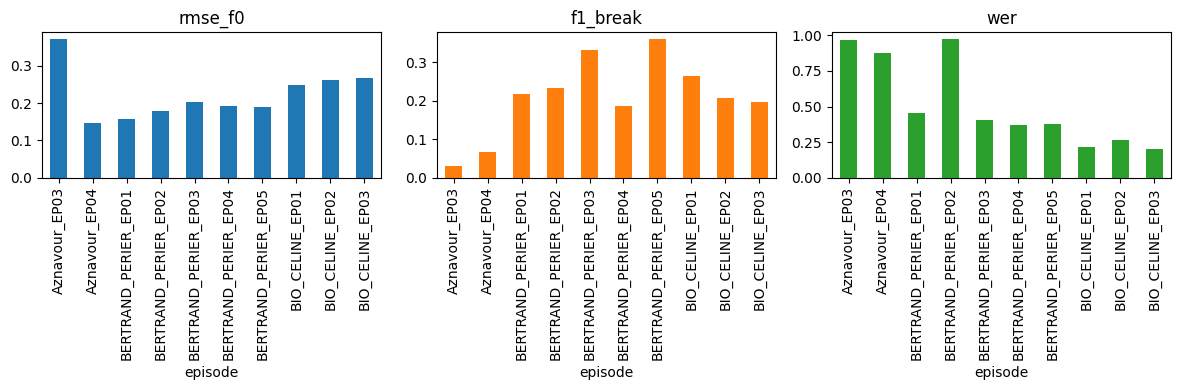

In [6]:
voice_base="/home/infres/horstmann-24/mon_projet_TTS/Data/voice"
results_base="/home/infres/horstmann-24/mon_projet_TTS/Out/results"
save_dir = "/home/infres/horstmann-24/mon_projet_TTS/Out/evaluation"

df = evaluate_all(voice_base, results_base, save_dir, parallel=False)

### Evaluate episodes in more detail

In [12]:
def compare_episode(ep_id: str, save_dir: str, wrap_width: int = 100):
    save_path = Path(save_dir) / ep_id
    ref_audio_path = save_path / "reference.wav"
    sys_audio_path = save_path / "synthetic.wav"
    ref_transcript_path = save_path / "reference_transcript.txt"
    sys_transcript_path = save_path / "synthetic_transcript.txt"

    # Load audio files
    y_ref, sr = librosa.load(ref_audio_path, sr=None)
    y_sys, _ = librosa.load(sys_audio_path, sr=sr)

    # Extract F0 (pitch)
    f0_ref = extract_f0_torchcrepe(y_ref, sr)
    f0_sys = extract_f0_torchcrepe(y_sys, sr)

    # Plot F0 contours with improvements
    plt.figure(figsize=(16, 4))  # Wider figure for better visibility
    times_ref = np.arange(len(f0_ref)) * (512 / sr)
    times_sys = np.arange(len(f0_sys)) * (512 / sr)
    plt.plot(times_ref, f0_ref, label="Reference F0", color="blue")
    plt.plot(times_sys, f0_sys, label="Synthetic F0", color="red", alpha=0.7)
    plt.xlabel("Time (s)")
    plt.ylabel("F0 (Hz)")
    plt.title(f"F0 Contour Comparison for {ep_id}")
    plt.legend()
    plt.grid(True)  # Add gridlines for better comparison
    plt.show()

    # Load segments for pause analysis
    with open(save_path / "reference_segments.json", "r") as f:
        ref_segments = json.load(f)
    with open(save_path / "synthetic_segments.json", "r") as f:
        sys_segments = json.load(f)

    # Function to create pause DataFrame with segment duration
    def create_pause_df(segments):
        data = []
        for i in range(len(segments) - 1):
            seg_text = segments[i]["text"].strip()
            seg_duration = segments[i]["end"] - segments[i]["start"]
            pause_duration = segments[i + 1]["start"] - segments[i]["end"]
            pause_str = f"{pause_duration:.2f}s" if pause_duration > 0.01 else "No Pause"
            data.append({
                "Segment Text": seg_text,
                "Segment Duration (s)": f"{seg_duration:.2f}",
                "Pause After": pause_str
            })
        return pd.DataFrame(data)

    # Create and display pause DataFrames
    ref_pause_df = create_pause_df(ref_segments)
    sys_pause_df = create_pause_df(sys_segments)
    print("Reference Segments and Pauses:")
    display(ref_pause_df)
    print("Synthetic Segments and Pauses:")
    display(sys_pause_df)

    # Load full transcripts
    with open(save_path / "reference_transcript.txt", "r") as f:
        ref_txt = f.read().strip()
    with open(save_path / "synthetic_transcript.txt", "r") as f:
        sys_txt = f.read().strip()

    # Wrap into fixed-width lines so difflib can align differences across the whole text
    ref_lines = textwrap.fill(ref_txt, width=wrap_width).splitlines()
    sys_lines = textwrap.fill(sys_txt, width=wrap_width).splitlines()

    # Generate an HTML side-by-side diff with context view
    hd = difflib.HtmlDiff(tabsize=4, wrapcolumn=wrap_width)
    diff_html = hd.make_file(
        ref_lines,
        sys_lines,
        fromdesc="Reference",
        todesc="Synthetic",
        context=True,      # show only changed blocks + a bit of context
        numlines=3         # context lines around each change
    )

    # Display in notebook
    display(HTML(diff_html))

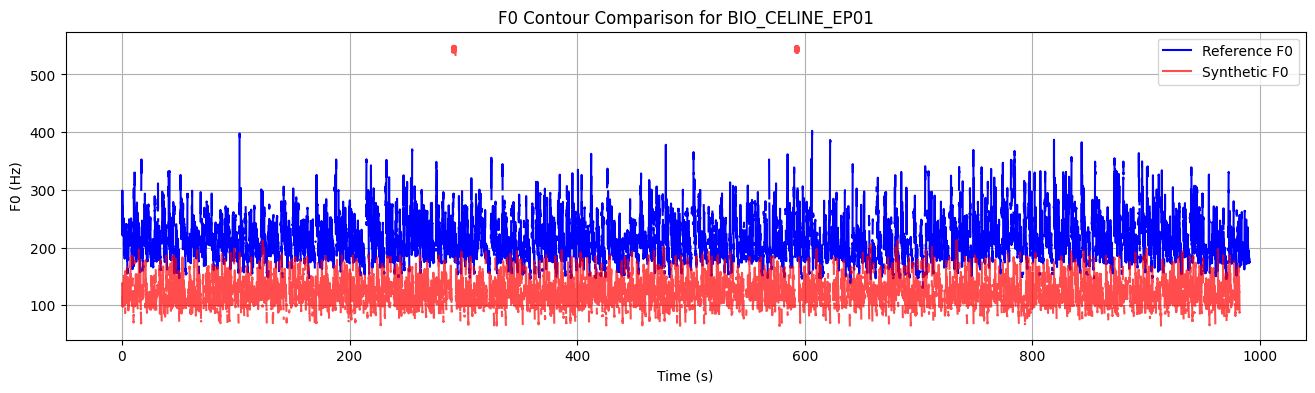

Reference Segments and Pauses:


,Segment Text,Segment Duration (s),Pause After
0,"Los Angeles, 5 février 2024, au Crypto.com Arena.",4.90,0.88s
1,"Miley Cyrus, Taylor Swift, les stars se presse...",3.54,0.78s
2,A la fin de la cérémonie arrive enfin le momen...,3.10,0.60s
3,celui où est décerné le Grammy du meilleur album.,2.26,0.82s
4,Qui va remettre la récompense ?,2.40,No Pause
...,...,...,...
441,Au revoir.,0.18,No Pause
442,Au revoir.,0.96,0.30s
443,Au revoir.,0.90,0.90s
444,Au revoir.,0.50,0.10s


Synthetic Segments and Pauses:


,Segment Text,Segment Duration (s),Pause After
0,"Loss, Angeles, 5 février 2024, au Crypto.com A...",10.36,0.68s
1,A la fin de la cérémonie arrive enfin le momen...,3.02,0.62s
2,Celui où est décerné le Grammy du meilleur album.,2.22,0.80s
3,Qui va remettre la récompense ?,2.48,No Pause
4,Le speaker annonce le nom de la remettante.,2.16,0.58s
...,...,...,...
357,Des choses.,0.04,No Pause
358,Des choses.,0.40,0.26s
359,Des choses.,0.18,0.20s
360,Des choses.,0.38,0.72s


In [13]:
compare_episode("BIO_CELINE_EP01", save_dir)